**Code for salinity mapping in Guinea-Bissau**:

**Autores:**

Gabriel Garbanzo León

Jesús Céspedes Rivera



**Google Colab** is free to use, but with limited capabilities as listed below.

1.   The runtime environment will restart after 10-15 minutes of inactivity or 12 hours of continuous computing.
2.   When the runtime environment restarts, all loaded/stored information and environment configuration is lost.

3. Resources are dynamically allocated according to the type of work being done.

4. In the case of jobs involving long-term computations, the use of hardware arranged in a computational cluster is suggested.

5. The management of the active sessions is done from the menu **Execution environment → Manage sessions**.

6. In order to avoid data loss and to back up the work done when the execution environment is restarted, it is also suggested to connect your Google Drive storage to Colab.

Star code

In [ ]:
 !pip install geemap

In [ ]:
pip install rasterstats

In [ ]:
# Importar librerias al entorno
import geemap
import ee

In [ ]:
# Iniciar Sesión en GEE (si les da un error incluso pegando el link de autenticación hay que conectar GEE con Google Cloud)
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=YfO2WGIyBICRsjnPSKvZDDHs1m9Vbbfug3exGGwebWg&tc=Axb2bstwg7C2ImN0VAeg78Qzmg4jbcRRObxnyRVkb5g&cc=FvzzzSCPlNnBeZf6TszzGnq2KkvzdhXMQWB2ED3iYbs

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXn7TpstfaAYU7TPIurJ2TxameMdaNMdCyq4xcV9mgPcb6rE2bCmDAo

Successfully saved authorization token.


In [ ]:

import geemap.chart as chart

import json
import pandas as pd



try:
    import geemap, ee
    import seaborn as sns
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print("package not found, installing w/ pip in Google Colab...")
        !pip install geemap seaborn matplotlib
    else:
        print("package not found, installing w/ conda...")
        !conda install mamba -c conda-forge -y
        !mamba install geemap -c conda-forge -y
        !conda install seaborn matplotlib -y
    import geemap, ee
    import seaborn as sns
    import matplotlib.pyplot as plt

In [ ]:
#Nota: Acá debemos dibujar un área de interés. Sino en adelante nos fallará el código.

Map = geemap.Map(center = (12.20, -16.36), zoom = 12)
Map

Map(center=[12.2, -16.36], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [ ]:
Map.user_roi.getInfo()
# Defina la geometria
geometry = Map.user_roi

NameError: ignored

In [ ]:
Map.user_roi.getInfo()

NameError: ignored

In [ ]:
# Asegurarnos de la creación de una geometría / Por si no la crearon en el mapa anterior.
geometry = ee.Geometry.Polygon([[[-16.458035, 12.233829],
   [-16.421471, 12.233829],
   [-16.421471, 12.257315],
   [-16.458035, 12.257315],
   [-16.458035, 12.233829]]])

In [ ]:
# The code has been copied to the clipboard.
# Press Ctrl+V to in a code cell to paste it.
###############/
collection = ee.ImageCollection("projects/planetscopejesus/assets/Datos_Gabo")

collection = collection.filterDate('2022-05-01', '2022-05-30').filterBounds(geometry)

#1.3) Adding Spectral Indices to the collection data######################/
##############################################/

# This function maps spectral indices for salinity Mapping using PlanetScope Imagery
def addIndices(img):
  # NDVI
  NDVI = img.normalizedDifference(['b8','b6']).rename('NDVI')
  SR = img.select('b8').divide(img.select('b6')).rename('SR')
  # GCVI
  GCVI = img.expression('(NIR/GREEN)-1',{
    'NIR':img.select('b8'),
    'GREEN':img.select('b3')
  }).rename('GCVI')
  # NDWI (GREEN-NIR)/(GREEN+NIR)
  NDWI = img.expression('(GREEN-NIR)/(GREEN+NIR)',{
    'NIR':img.select('b8'),
    'GREEN':img.select('b3')
  }).rename('NDWI')
  # VARI (Green−Red)/(Green+Reed−Blue)
  VARI = img.expression('(Green1-Red)/(Green1+Red-Blue)',{
    'Blue':img.select('b2'),
    'Red':img.select('b6'),
    'Green1':img.select('b3') }).rename('VARI')
  # GRVI (NIR/GREEN)
  GRVI = img.expression('(NIR/GREEN)',{
    'NIR':img.select('b8'),
    'GREEN':img.select('b3')
  }).rename('GRVI')
  # GNDVI (NIR-GREEN)/(NIR+GREEN)
  GNDVI = img.normalizedDifference(['b8','b3']).rename('GNDVI')
  # S1 (Blue/Red)
  S1 = img.select('b2').divide(img.select('b6')).rename('S1')
  # S1 (B − R)/(B + R)
  S2 = img.expression('(Blue-Red)/(Blue + Red)',{
    'Blue':img.select('b2'),
    'Red':img.select('b6') }).rename('S2')
  # S3_G1 (G1 × R)/B
  S3_G1 = img.expression('(Green1*Red)/(Blue)',{
    'Blue':img.select('b2'),
    'Red':img.select('b6'),
    'Green1':img.select('b3') }).rename('S3_G1')
  # S3_G2 (G1 × R)/B
  S3_G2 = img.expression('(Green2*Red)/(Blue)',{
    'Blue':img.select('b2'),
    'Red':img.select('b6'),
    'Green2':img.select('b4') }).rename('S3_G2')
  # S4 (B×R)**0.5
  S4 = img.expression('(Blue*Red)**0.5',{
    'Blue':img.select('b2'),
    'Red':img.select('b6')}).rename('S4')
  # S5_G1 ((B × R)/G1)
  S5_G1= img.expression('(Blue*Red)/Green1',{
    'Blue':img.select('b2'),
    'Green1':img.select('b3'),
    'Red':img.select('b6')}).rename('S5_G1')
  # S5_G2 ((B × R)/G1)
  S5_G2 = img.expression('(Blue*Red)/Green2',{
    'Blue':img.select('b2'),
    'Green2':img.select('b4'),
    'Red':img.select('b6')}).rename('S5_G2')
 # S6_G1 (R × NIR)/G1
  S6_G1 = img.expression('(Red*NIR)/Green1',{
    'NIR':img.select('b8'),
    'Green1':img.select('b3'),
    'Red':img.select('b6')}).rename('S6_G1')
  # S6_G2 (R × NIR)/G2
  S6_G2 = img.expression('(Red*NIR)/Green1',{
    'NIR':img.select('b8'),
    'Green1':img.select('b3'),
    'Red':img.select('b6')}).rename('S6_G2')
  # SI (B+R)**0.5
  SI = img.expression('(Blue+Red)**0.5',{
    'Blue':img.select('b2'),
    'Red':img.select('b6')}).rename('SI')
  # NDSI (R − NIR)/(R + NIR)
  NDSI = img.normalizedDifference(['b6','b8']).rename('NDSI')
  # SI1_G1 (G1×R)**0.5
  SI1_G1 = img.expression('(Green1*Red)**0.5',{
    'Green1':img.select('b3'),
    'Red':img.select('b6')}).rename('SI1_G1')
  # SI1_G2 (G1×R)**0.5
  SI1_G2 = img.expression('(Green2*Red)**0.5',{
    'Green2':img.select('b4'),
    'Red':img.select('b6')}).rename('SI1_G2')
  # SI2_G1 [(G1)**2 + (R)**2 + (NIR)**2]**0.5
  SI2_G1 = img.expression('((Green1)**2 + (Red)**2 + (NIR)**2)**0.5',{
    'NIR':img.select('b8'),
    'Green1':img.select('b3'),
    'Red':img.select('b6')}).rename('SI2_G1')
  # SI2_G2 [(G2)**2 + (R)**2 + (NIR)**2]**0.5
  SI2_G2 = img.expression('((Green2)**2 + (Red)**2 + (NIR)**2)**0.5',{
    'NIR':img.select('b8'),
    'Green2':img.select('b4'),
    'Red':img.select('b6')}).rename('SI2_G2')
  # SI3_G1 ((G1)**2 + (R)**2)**0.5
  SI3_G1 = img.expression('((Green1)**2 + (Red)**2)**0.5',{
    'Green1':img.select('b3'),
    'Red':img.select('b6')}).rename('SI3_G1')
  # SI3_G2 ((G1)**2 + (R)**2)**0.5
  SI3_G2 = img.expression('((Green2)**2 + (Red)**2)**0.5',{
    'Green2':img.select('b4'),
    'Red':img.select('b6')}).rename('SI3_G2')
  # Int1_G1 (G1 + R)/2
  Int1_G1 = img.expression('(Green1+Red)/2',{
    'Green1':img.select('b3'),
    'Red':img.select('b6')}).rename('Int1_G1')
  # Int1_G2 (G2 + R)/2
  Int1_G2 = img.expression('(Green2+Red)/2',{
    'Green2':img.select('b4'),
    'Red':img.select('b6')}).rename('Int1_G2')
  # Int2_G1 (G1 + R + NIR)/2
  Int2_G1 = img.expression('(Green1 + Red + NIR)/2',{
    'NIR':img.select('b8'),
    'Green1':img.select('b3'),
    'Red':img.select('b6')}).rename('Int2_G1')
  # Int2_G2 (G1 + R + NIR)/2
  Int2_G2 = img.expression('(Green2 + Red + NIR)/2',{
    'NIR':img.select('b8'),
    'Green2':img.select('b4'),
    'Red':img.select('b6')}).rename('Int2_G2')
  return img \
    .addBands(NDVI)\
    .addBands(SR) \
    .addBands(GCVI) \
    .addBands(NDWI) \
    .addBands(VARI) \
    .addBands(GNDVI)\
    .addBands(GRVI) \
    .addBands(S1) \
    .addBands(S2) \
    .addBands(S3_G1) \
    .addBands(S3_G2) \
    .addBands(S4) \
    .addBands(S5_G1) \
    .addBands(S5_G2) \
    .addBands(S6_G1) \
    .addBands(S6_G2) \
    .addBands(SI) \
    .addBands(NDSI) \
    .addBands(SI1_G1) \
    .addBands(SI1_G2) \
    .addBands(SI2_G1) \
    .addBands(SI2_G2) \
    .addBands(SI3_G1) \
    .addBands(SI3_G2) \
    .addBands(Int1_G1) \
    .addBands(Int1_G2) \
    .addBands(Int2_G1) \
    .addBands(Int2_G2) \

ps = collection

#Add the indices
ps_1 = ps.map(addIndices)


composite = ps_1 \
              .mean()\
              .float()
              # Clips the composite to our area of interest

Map.addLayer(composite, {'bands': ['b6',  'b4',  'b2'], 'min': 201, 'max': 2464}, 'RGB')
Map.addLayer(composite, {'bands': ['S1',  'S2',  'S3_G1'], 'min': 0, 'max': 1}, 'Index')

export = composite.select(["b8", "GRVI", "GNDVI", "NDWI", "GCVI", "SR", "NDVI", "S6_G1", "S6_G2" ,"NDSI"])

In [ ]:
geemap.ee_export_image_to_drive(
    export, description='PS_Index_9_m', folder='GEE', region=geometry, scale= 3, crs = 'EPSG:2095'
)

# Call the libraries

In [ ]:
# Requirements, will skip if already installed
%pip install geopandas rasterio rasterstats shapely
%pip install folium earthengine-api
%pip install scikit-learn
%pip install treeinterpreter

In [ ]:
from os import path as op
import pickle

from osgeo import gdal
import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
import rasterstats
import folium

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# your root directory for outputs is set to your google drive
# you should create a sub-folder called data under your 'Colab Notebooks'.
# An example is in https://developmentseed.org/sat-ml-training/GettingStarted#Explore-your-drive
my_root_dir = "/content/drive/My Drive/Datos/GEE"

Add the training data (digitalized in QGIS) and later charged to Drive

In [ ]:
# read in training data polygons that created as geojson from a shared directory
training_data = '/content/drive/My Drive/GEE/Elalab_1.geojson'
training_vectors = gpd.read_file(training_data)

# make a bounding box and centroid for mapping
bbox = training_vectors.total_bounds
center = shp.geometry.box(bbox[0], bbox[1], bbox[2], bbox[3]).centroid

# show the 1st 5 lines
training_vectors.head()

,ogc_fid,id,U_Field1,U_Field2,U_Field3,Ca,Mg,K,Na,Bases,SB,CE12,CE,pH,Acidez,geometry
0,1,1.0,M-EL 1,NaN,NaN,1.72,7.63,0.66,34.78,44.79,3269.340000,28.9,113.269,6.4,0.07,POINT (341286.657 1354108.826)
1,2,2.0,M-EL 2,NaN,NaN,5.75,16.81,4.35,81.83,108.74,546.160000,30.9,121.089,6.1,0.10,POINT (341286.657 1353805.826)
2,3,3.0,M-EL 3,NaN,NaN,2.92,14.30,2.81,59.10,79.13,686.890000,31.0,121.480,5.9,0.07,POINT (341286.657 1353654.326)
3,4,4.0,M-EL 4,NaN,NaN,4.82,31.39,7.69,137.36,181.26,1145.764855,58.3,228.223,5.6,0.10,POINT (341438.157 1354108.826)
4,5,5.0,M-EL 5,NaN,NaN,3.34,9.94,1.42,67.83,82.53,3034.190000,39.1,153.151,6.3,0.10,POINT (341438.157 1353957.326)


In [ ]:
# find all unique values of training data names to use as classes
classes = training_vectors[['CE12']]
classes.shape

(98, 1)

In [ ]:
from os import path as op
import pickle

from osgeo import gdal
import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
import rasterstats
import folium

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti

import numpy as np
import pandas as pd

# Load Packages
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.regularizers import l2
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn import metrics
import tensorflow as tf

In [ ]:
from shapely.geometry import shape, box

# Define the buffer distance (in raster units or coordinates)
buffer_distance = 9  # Adjust this distance as needed

##If you want to read the data directly from the shared folder, uncomment the following line.
raster_file = '/content/drive/My Drive/GEE/PS_Index_9_m.tif'


# # a custom function for getting each value from the raster
# def all_values(x):
#     return x

X_raw = []
y_raw = []
with rasterio.open(raster_file, 'r') as src:
    for (label, geom) in zip(training_vectors.SB, training_vectors.geometry):
        # Create a buffered geometry
        buffered_geom = geom.buffer(buffer_distance)

        # Get the bounds of the buffered geometry
        buffered_bounds = buffered_geom.bounds

        # Use the buffered bounds to create the window
        window = bounds_window(buffered_bounds, src.transform)

        window_affine = src.window_transform(window)
        fsrc = src.read(window=window)
        mask = rasterize(
            [(buffered_geom, 1)],
            out_shape=fsrc.shape[1:],
            transform=window_affine,
            fill=0,
            dtype='uint16',
            all_touched=True
        ).astype(bool)
        label_pixels = np.argwhere(mask)

        buffer_values = []  # Lista para almacenar los valores de píxeles en el buffer
        for (row, col) in label_pixels:
            data = fsrc[:, row, col]
            one_x = np.nan_to_num(data, nan=1e-3)
            buffer_values.append(one_x)

        # Calcular el valor promedio dentro del buffer
        if buffer_values:
            average_value = np.mean(buffer_values, axis=0)
            X_raw.append(average_value)
            y_raw.append(training_vectors['CE12'])

In [ ]:
X = np.array(X_raw)
y = np.array(training_vectors['CE12'])
y = y.ravel()

(X.shape, y.shape)

((98, 10), (98,))

In [ ]:
datos_index = pd.DataFrame(X, columns = ["B8", "GRVI", "GNDVI", "NDWI", "GCVI", "SR", "NDVI", "S6_G1", "S6_G2" ,"NDSI"])

X = datos_index[["B8", "GRVI", "GNDVI", "NDWI", "GCVI", "SR", "NDVI", "S6_G1", "S6_G2" ,"NDSI"]]
print(X)

             B8      GRVI     GNDVI      NDWI      GCVI        SR      NDVI  \
0   2373.142822  2.031812  0.340110 -0.340110  1.031812  1.539543  0.211845   
1   2076.023926  1.763965  0.276013 -0.276013  0.763965  1.417009  0.172283   
2   2074.285645  1.859244  0.300271 -0.300271  0.859244  1.470754  0.190310   
3   2679.023926  2.245807  0.383508 -0.383508  1.245808  1.553787  0.216527   
4   2468.261963  2.030901  0.340003 -0.340003  1.030901  1.439023  0.179831   
..          ...       ...       ...       ...       ...       ...       ...   
93  2579.102539  1.960642  0.324064 -0.324064  0.960643  1.507684  0.202281   
94  2813.256348  2.120274  0.358657 -0.358657  1.120275  1.511725  0.203381   
95  2520.769287  1.979969  0.328373 -0.328373  0.979969  1.473073  0.190821   
96  2747.051270  2.089687  0.352552 -0.352552  1.089687  1.510267  0.203203   
97  2257.829346  2.009181  0.334925 -0.334925  1.009181  1.540663  0.212345   

          S6_G1        S6_G2      NDSI  
0   3137.8

In [ ]:
datos_SB = pd.DataFrame(y, columns = ["CE12"])

y = datos_SB


print(datos_SB)

    CE12
0   28.9
1   30.9
2   31.0
3   58.3
4   39.1
..   ...
93   2.7
94  17.9
95   1.3
96  42.0
97  76.9

[98 rows x 1 columns]


In [ ]:
datos = pd.concat([datos_SB,datos_index], axis =1).dropna()
datos = pd.DataFrame(datos, columns = ['CE12',"B8", "GRVI", "GNDVI", "NDWI", "GCVI", "SR", "NDVI", "S6_G1", "S6_G2" ,"NDSI"]).dropna()

print(datos)

    CE12           B8      GRVI     GNDVI      NDWI      GCVI        SR  \
0   28.9  2373.142822  2.031812  0.340110 -0.340110  1.031812  1.539543   
1   30.9  2076.023926  1.763965  0.276013 -0.276013  0.763965  1.417009   
2   31.0  2074.285645  1.859244  0.300271 -0.300271  0.859244  1.470754   
3   58.3  2679.023926  2.245807  0.383508 -0.383508  1.245808  1.553787   
4   39.1  2468.261963  2.030901  0.340003 -0.340003  1.030901  1.439023   
..   ...          ...       ...       ...       ...       ...       ...   
93   2.7  2579.102539  1.960642  0.324064 -0.324064  0.960643  1.507684   
94  17.9  2813.256348  2.120274  0.358657 -0.358657  1.120275  1.511725   
95   1.3  2520.769287  1.979969  0.328373 -0.328373  0.979969  1.473073   
96  42.0  2747.051270  2.089687  0.352552 -0.352552  1.089687  1.510267   
97  76.9  2257.829346  2.009181  0.334925 -0.334925  1.009181  1.540663   

        NDVI        S6_G1        S6_G2      NDSI  
0   0.211845  3137.839600  3137.839600 -0.211845

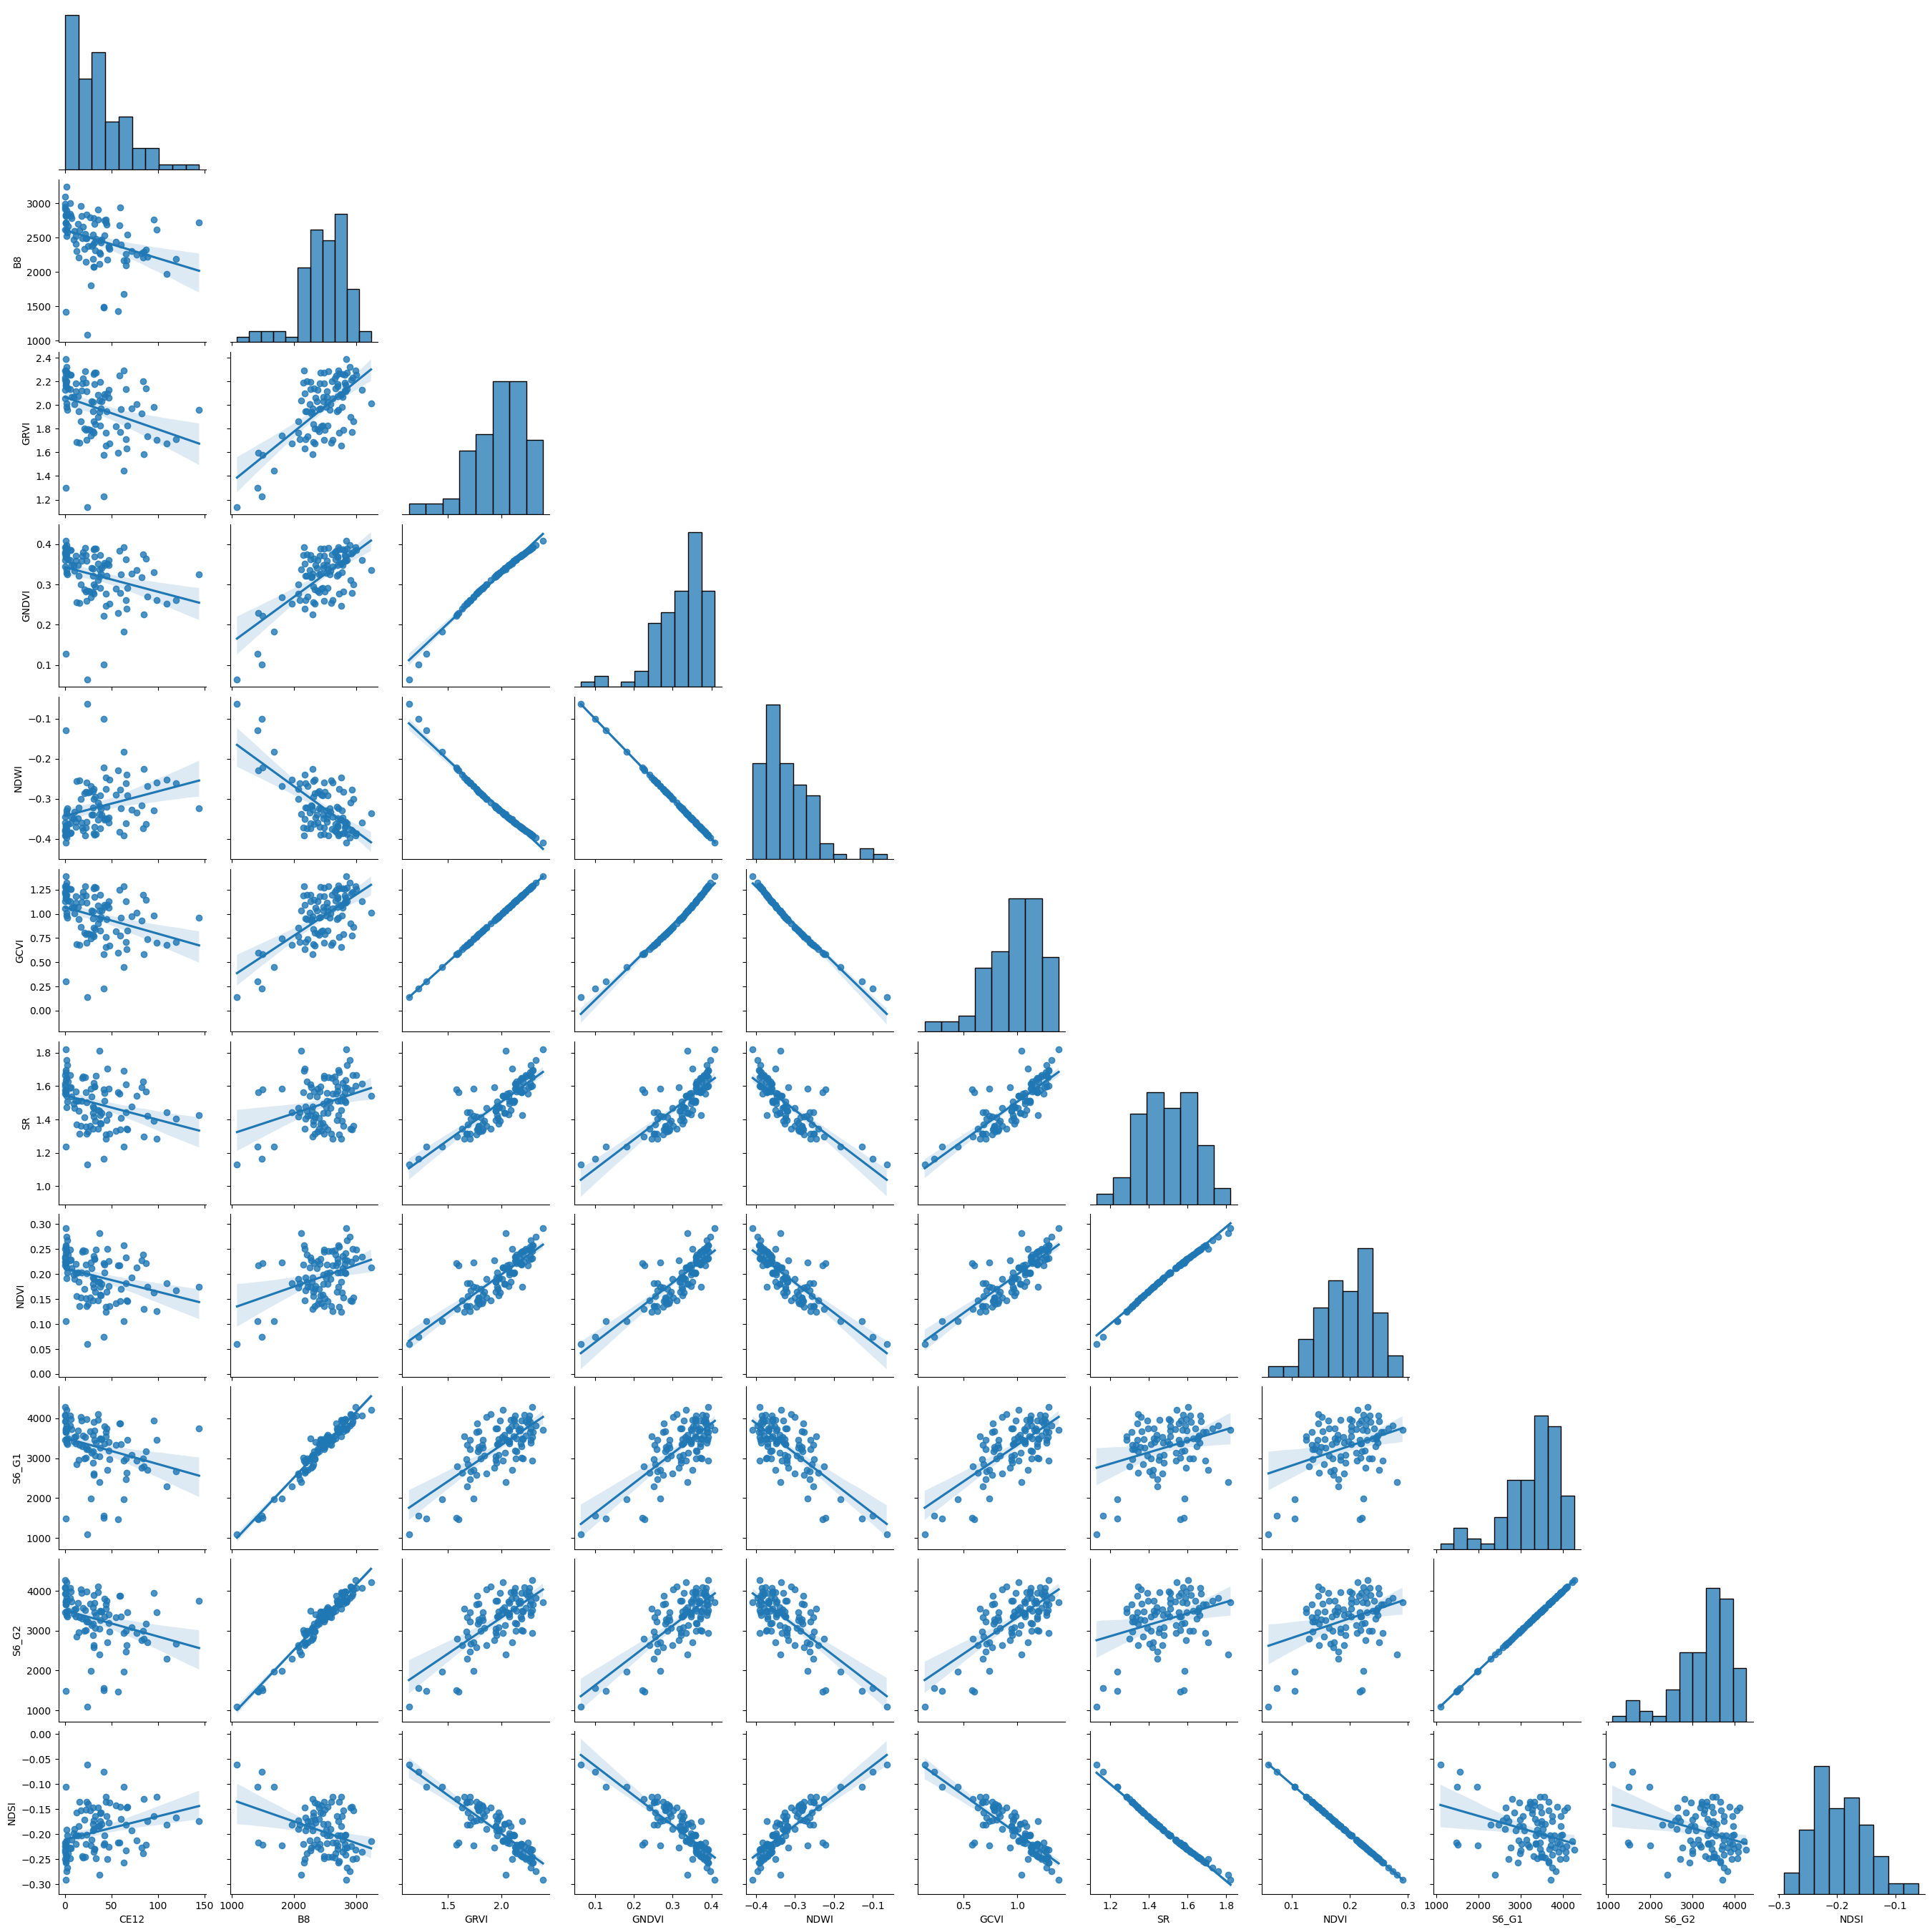

In [ ]:
# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt

# Basic correlogram
plot = sns.pairplot(datos, corner = True, vars = ['CE12',"B8", "GRVI", "GNDVI", "NDWI", "GCVI", "SR", "NDVI", "S6_G1", "S6_G2" ,"NDSI"], kind = "reg", diag_kind="hist")

plt.show()

# B8

<Axes: >

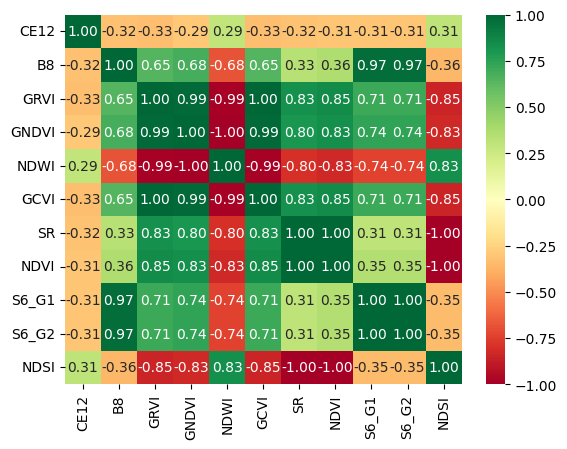

In [ ]:
datoscorr = datos[["CE12", "B8", "GRVI", "GNDVI", "NDWI", "GCVI", "SR", "NDVI", "S6_G1", "S6_G2" ,"NDSI"]]
cormat = datoscorr.corr()
round(cormat,2)

sns.heatmap(cormat,annot=True, fmt='.2f', cmap='RdYlGn')

In [ ]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

print(X_train)


             B8      GRVI     GNDVI      NDWI      GCVI        SR      NDVI  \
36  2487.404785  1.702826  0.259832 -0.259832  0.702826  1.314968  0.135935   
22  2308.666748  1.688371  0.255801 -0.255801  0.688370  1.370753  0.156253   
45  2402.000000  1.779996  0.280390 -0.280390  0.779996  1.344921  0.147008   
30  2602.690430  1.679408  0.253421 -0.253421  0.679408  1.313205  0.135174   
15  2540.976074  2.027341  0.339058 -0.339058  1.027341  1.440150  0.179873   
..          ...       ...       ...       ...       ...       ...       ...   
93  2579.102539  1.960642  0.324064 -0.324064  0.960643  1.507684  0.202281   
11  2527.214355  2.114655  0.357620 -0.357620  1.114654  1.510257  0.202179   
25  2473.214355  2.068777  0.348083 -0.348083  1.068777  1.495672  0.198388   
85  3002.923096  2.256023  0.385624 -0.385624  1.256023  1.664474  0.249103   
76  2850.230713  2.271846  0.388491 -0.388491  1.271846  1.727708  0.266628   

          S6_G1        S6_G2      NDSI  
36  3222.6

# Prepare the RF process for make the classification

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
# fit the model to the data (training)
model = DecisionTreeRegressor()
model.fit(X_train , y_train)
y_pred = model.predict(X_test)

print(y_pred)

[ 36.9  95.1  15.1  35.2  41.6   1.2   0.5   2.3 119.2  21.6  44.2  30.9
  26.8  59.8  63.4  87.1   5.2  41.6  42.7  44.2]


In [ ]:
model = DecisionTreeRegressor(criterion='absolute_error', max_depth=100)
model.fit(X_train , y_train)
ypred = model.predict(X_test)
cross_val_score(model, X, y, cv=10)

array([-6.65873182e+00, -9.35725739e+00, -6.56112008e+00, -1.75528437e+00,
       -1.17912812e+01, -2.20806231e+00, -2.29948650e+00, -2.76625780e+02,
       -1.14061025e-01,  3.49548825e-01])

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_test, model.predict(X_test)))
print(model.score(X_test, y_test))

-0.2618353415056818
-0.2618353415056818


R2 Score: -0.2263402621962496


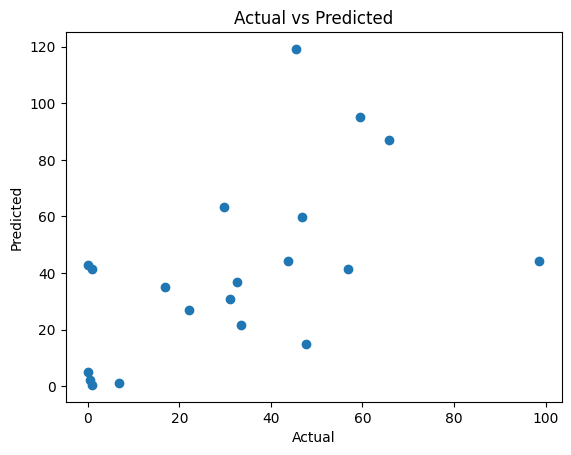

In [ ]:
print("R2 Score:", r2_score(y_test, y_pred))

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted")
plt.show()

In [ ]:
# your root directory for outputs is set to your google drive
# you should create a sub-folder called data under your 'Colab Notebooks'.
# An example is in https://developmentseed.org/sat-ml-training/GettingStarted#Explore-your-drive
my_root_dir = "/content/drive/My Drive/GEE/"

In [ ]:
# in this case, we predict over the entire input image
# (only small portions were used for training)
new_image = raster_file

# specify the output
output_image = op.join(my_root_dir, "classification_9m.tif")

with rasterio.open(new_image, 'r') as src:
    profile = src.profile
    profile.update(
        dtype=rasterio.uint8,
        count=1,
    )
    with rasterio.open(output_image, 'w', **profile) as dst:

        # perform prediction on each small image patch to minimize required memory
        patch_size = 500

        for i in range((src.shape[0] // patch_size) + 1):
            for j in range((src.shape[1] // patch_size) + 1):
                # define the pixels to read (and write) with rasterio windows reading
                window = rasterio.windows.Window(
                    j * patch_size,
                    i * patch_size,
                    # don't read past the image bounds
                    min(patch_size, src.shape[1] - j * patch_size),
                    min(patch_size, src.shape[0] - i * patch_size))

                # read the image into the proper format
                data = src.read(window=window)

                # adding indices if necessary
                img_swp = np.moveaxis(data, 0, 2)
                img_flat = img_swp.reshape(-1, img_swp.shape[-1])

                # img_ndvi = band_index(img_flat, 3, 2)
                # img_ndwi = band_index(img_flat, 1, 3)

                #img_w_ind = np.concatenate([img_flat, img_ndvi, img_ndwi], axis=1)
                img_w_ind = img_flat

                # remove no data values, store the indices for later use
                m = np.ma.masked_invalid(img_w_ind)
                to_predict = img_w_ind[~m.mask].reshape(-1, img_w_ind.shape[-1])

                # skip empty inputs
                if not len(to_predict):
                    continue
                # predict
                img_preds = model.predict(to_predict)

                # add the prediction back to the valid pixels (using only the first band of the mask to decide on validity)
                # makes the assumption that all bands have identical no-data value arrangements
                output = np.zeros(img_flat.shape[0])
                output[~m.mask[:, 0]] = img_preds.flatten()
                # resize to the original image dimensions
                output = output.reshape(*img_swp.shape[:-1])

                # create our final mask
                mask = (~m.mask[:, 0]).reshape(*img_swp.shape[:-1])

                # write to the final files
                dst.write(output.astype(rasterio.uint8), 1, window=window)
                dst.write_mask(mask, window=window)

<Axes: >

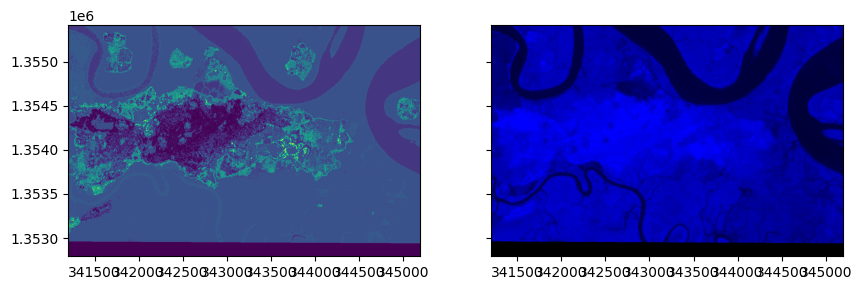

In [ ]:
### Visualize the results
import matplotlib.pyplot as plt
from rasterio.plot import show
%matplotlib inline

# Load the original image
# Load the classification

output_image = '/content/drive/My Drive/GEE/classification_9m.tif'

def linear_rescale(image, in_range=(0, 1), out_range=(1, 255)):
    imin, imax = in_range
    omin, omax = out_range
    image = np.clip(image, imin, imax) - imin
    image = image / np.float(imax - imin)
    return image * (omax - omin) + omin

with rasterio.open(output_image, 'r') as class_raster:
#  show(class_raster)
  classes = class_raster.read()

# Compare side by side
with rasterio.open(raster_file, 'r') as p4_raster:
#  show(p4_raster)
  p4 = p4_raster.read([1,2,3])
  for band in range(p4.shape[0]):
    p4[band] = linear_rescale(
            p4[band],
            in_range=(0, 3000),
            out_range=[0, 255]
        )
  p4 = p4.astype(np.uint8)
  #print(s2.shape)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), sharey=True)
show(classes, transform=class_raster.transform, ax=ax1)
show(p4[[2,1,0], : , :], transform=p4_raster.transform, adjust='linear', ax=ax2)


In [ ]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

print('MAE on train:', mae(y_train, model.predict(X_train)))
print('MAE on test:', mae(y_test, model.predict(X_test)))

MAE on train: 0.0
MAE on test: 19.924999999999997


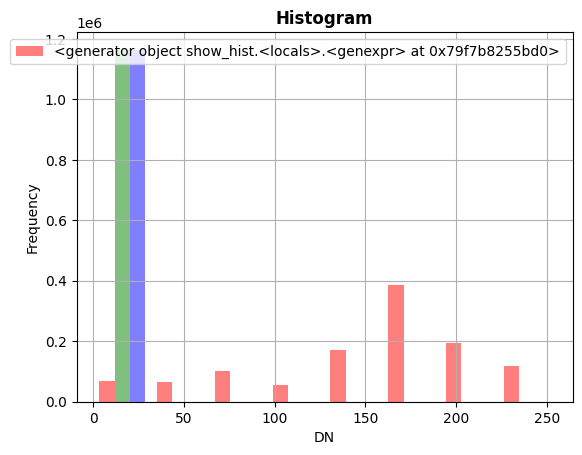

In [ ]:
# Exploring why the imagery is so dark.
# Looks like it will need manual stretching to make a nice image
rasterio.plot.show_hist(p4,
                   bins=8,
                   lw=0.9,
                   alpha=0.5)